<a href="https://colab.research.google.com/github/NorWanK/HelloWorld/blob/master/VA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -U pandas-profiling
import warnings
warnings.filterwarnings('ignore')
!pip install geopandas

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 133kB 4.8MB/s 
     |████████████████████████████████| 614kB 37.6MB/s 
     |████████████████████████████████| 235kB 41.2MB/s 
     |████████████████████████████████| 307kB 43.3MB/s 
     |████████████████████████████████| 215kB 34.1MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 737kB 50.0MB/s 
  Created wheel for p

     |████████████████████████████████| 921kB 4.8MB/s 
     |████████████████████████████████| 10.1MB 13.9MB/s 
     |████████████████████████████████| 11.8MB 198kB/s 


In [0]:
ToBeDropped=['availability_30','availability_365',
             'availability_60','availability_90','country',
             'country_code','host_location','host_name','host_picture_url',
             'host_since','maximum_nights','minimum_nights','name','picture_url'
             ,'requires_license','require_guest_profile_picture','require_guest_phone_verification'
             ,'listing_url','listing_url','license','host_thumbnail_url','zipcode','calendar_last_scraped'
             ,'scrape_id','is_location_exact','instant_bookable','has_availability','host_has_profile_pic'
             ,'host_about','house_rules','calculated_host_listings_count','suburb'
             ,'street','summary','transit','state','space','smart_location','notes'
             ,'neighborhood_overview','last_scraped','interaction','description'
             ,'calendar_updated','access','host_url']
import pandas as pd
import pandas_profiling
Listings = pd.read_csv('/content/drive/My Drive/cleansed_listings_dec18.csv')
Listings.drop(labels=ToBeDropped , inplace=True, axis=1)


In [0]:
Listings.profile_report(style={'full_width':True})

# many simple values should be dropped first since they have no valueable information about the properties or serious effort is needed to make them work


#taking Care of Nans one by one
##Bathrooms

In [0]:
#print(Listings.groupby('bedrooms').bathrooms.mean())
#print(Listings.groupby('bedrooms').bathrooms.std())
#print(Listings.loc[Listings.bathrooms.isna()==True].bedrooms.unique())## only one bedroom listings have nan value
Listings.bathrooms.fillna(value=1,inplace=True)

##Bedrooms


In [0]:
#print(Listings.groupby('bathrooms').bedrooms.mean())
#print(Listings.groupby('bathrooms').bedrooms.std())
#missing value spotted on 2 bathroom places
#print(Listings.loc[Listings.bedrooms.isna()==True].bathrooms.unique())
##
#Listings[Listings.bathrooms==1].bedrooms.fillna(value=1,inplace=True)
#Listings[Listings.bathrooms==2].bedrooms.fillna(value=2,inplace=True)
Listings.loc[(Listings.bathrooms==1)&(Listings.bedrooms.isna()==True),'bedrooms']=1
Listings.loc[(Listings.bathrooms==2)&(Listings.bedrooms.isna()==True),'bedrooms']=2


###Beds

In [0]:

#print(Listings.groupby('bedrooms').beds.mean())
#print(Listings.groupby('bedrooms').beds.std())
#missing value spotted on 2 bathroom places
#print(Listings.loc[Listings.beds.isna()==True].bedrooms.unique())
##
Listings.loc[(Listings.beds.isna()==True)&(Listings.bedrooms==0),'beds']=1
Listings.loc[(Listings.beds.isna()==True)&(Listings.bedrooms==1),'beds']=1
Listings.loc[(Listings.beds.isna()==True)&(Listings.bedrooms==2),'beds']=2
Listings.loc[(Listings.beds.isna()==True)&(Listings.bedrooms==4),'beds']=3


# Can neighbourhood be approximated by geographical features?
Using Neighbourhood.geojason each listing's region was approximated.

In [0]:
#print(Listings.groupby('host_neighborhood').neighborhood.value_counts())
#print(Listings.loc[Listings.neighborhood.isna()==True].host_neighborhood.value_counts())
## lets see if we find a relation ship between host neighbourhood and listing's neibourhood
for i in Listings.dropna().host_neighborhood.unique():
      temp =Listings.loc[Listings.host_neighborhood==i] 
      temp=temp.groupby(['neighborhood'])['host_neighborhood'].value_counts().rename('count').reset_index()
      val =temp.iloc[0]['neighborhood']
      #filling the value
      Listings.loc[(Listings.host_neighborhood==i)
                        &(Listings.neighborhood.isna()==True),'neighbourhood']=val
##

In [0]:

Data=Listings[['longitude','latitude','neighbourhood','price']].copy()
NoLabel=Data.loc[Data.neighbourhood.isna()==True]
Data.dropna(inplace=True)
# using these features
X= Data[['longitude','latitude','price']]
y= Data['neighbourhood']
#df = pd.get_dummies(X['street'])
#X = pd.concat([X, df], axis=1, join='inner')
#X.drop('street',axis=1,inplace=True)

### lets plot the neighbourhoods and see if we can use KNN or not
color and price should be fixed

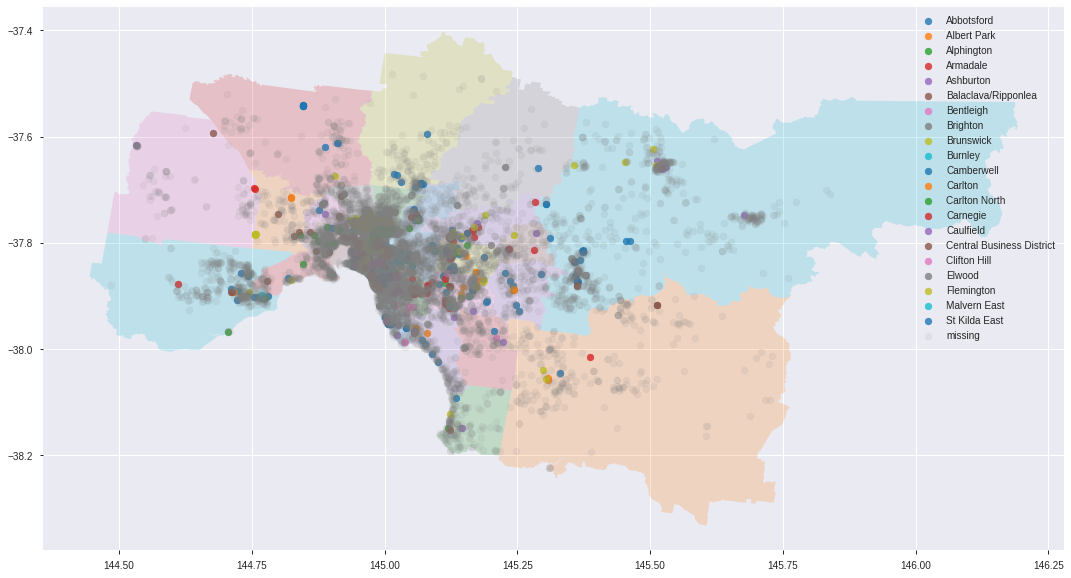

In [0]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
df_places = gpd.read_file('/content/neighbourhoods.geojson')
ax = df_places.plot(column='neighbourhood',alpha=0.21)
scatter_x = Data['longitude'].values
scatter_y = Data['latitude'].values
scatter_s = Data['price'].values
group = Data.neighbourhood.values
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g,alpha=0.8,)
ax.scatter(NoLabel['longitude'],NoLabel['latitude'], label='missing',c='gray',alpha=0.1,)
ax.legend()
ax.figure.set_size_inches(20, 10)
plt.show()

In [0]:
X.isna().sum()
X.shape
Cop = X.copy()

### we make a simple logistic regression model and see how it preforms on our data.

In [0]:
X=Cop.copy()
########----------------------------
def GridSearch(X_train,y_train,mdl,params,cv,sc):
  from sklearn.model_selection import GridSearchCV
  cvg= GridSearchCV(mdl,verbose=1,scoring=Sc,param_grid=params,n_jobs=-1,cv=Cv)
  res=cvg.fit(X_train,y_train)
  return res
#####-----------------------------------
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import Normalizer

X.drop('price',inplace=True,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

Cv=5
Sc='f1_macro'
Sc='accuracy'
Sc='f1_weighted'
#### logistic regression -> not good at all, poor accuracy and F1 scroe
from sklearn.linear_model import LogisticRegression
params={'max_iter':np.linspace(100,1500,15)}
mdl= LogisticRegression()
### rando forest tree model and params
"""
from sklearn.ensemble import RandomForestClassifier
mdl =RandomForestClassifier(n_jobs=-1)
params={'n_estimators':[2000]
        ,'max_depth':[4]}
        """
###  
from sklearn.neighbors import KNeighborsClassifier
mdl = KNeighborsClassifier()
params={'n_neighbors':[1,3,5,7,9],
        'p':[1,2],
        'weights' :['uniform','distance'],}
res=GridSearch(X_train,y_train,mdl,params,Cv,Sc)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished


In [0]:
res.best_score_
#res.best_params_

0.7768158325554653

In [0]:
temp= Listings.copy()
import json
from shapely.geometry import shape, Point
# depending on your version, use: from shapely.geometry import shape, Point
nb=Data.neighbourhood.unique()
# load GeoJSON file containing sectors

def func(row):
    point = Point(row['longitude'],row['latitude'])
# check each polygon to see if it contains the point
    for feature in func.js['features']:
      polygon = shape(feature['geometry'])
      name =feature['properties']['neighbourhood']
      if polygon.contains(point):
          return name

with open('neighbourhoods.geojson') as f:
     func.js = json.load(f)


temp['NBR']=temp[['longitude','latitude']].apply(func,axis=1)
temp.head()
Listings['nbr']= temp['NBR']

In [0]:
### missing values so small that they are not significant
Listings.loc[Listings.host_identity_verified.isna()==True,
             'host_identity_verified']='f'
Listings.loc[Listings.host_is_superhost.isna()==True,
             'host_is_superhost']='f'


In [0]:
import pandas as pd
import numpy as np

Listings = pd.read_csv('/content/drive/My Drive/semi_cleaned.csv')
NewDropList=['host_id','host_url','neighborhood','neighbourhood'
             ,'monthly_price'
             ,'weekly_price','host_neighborhood','Unnamed: 0','city'
             ,'first_review'
             ,'last_review']

Listings.drop(NewDropList,axis=1,inplace=True)
Listings.dropna(inplace=True)
Listings.head()


id host_response_time  ... reviews_per_month           nbr
2  12936     within an hour  ...              0.15  Port Phillip
5  38271     within an hour  ...              1.14         Casey
7  43414     within an hour  ...              0.29     Melbourne
8  43429     within an hour  ...              1.72        Monash
9  44082     within an hour  ...              0.29     Frankston

[5 rows x 32 columns]

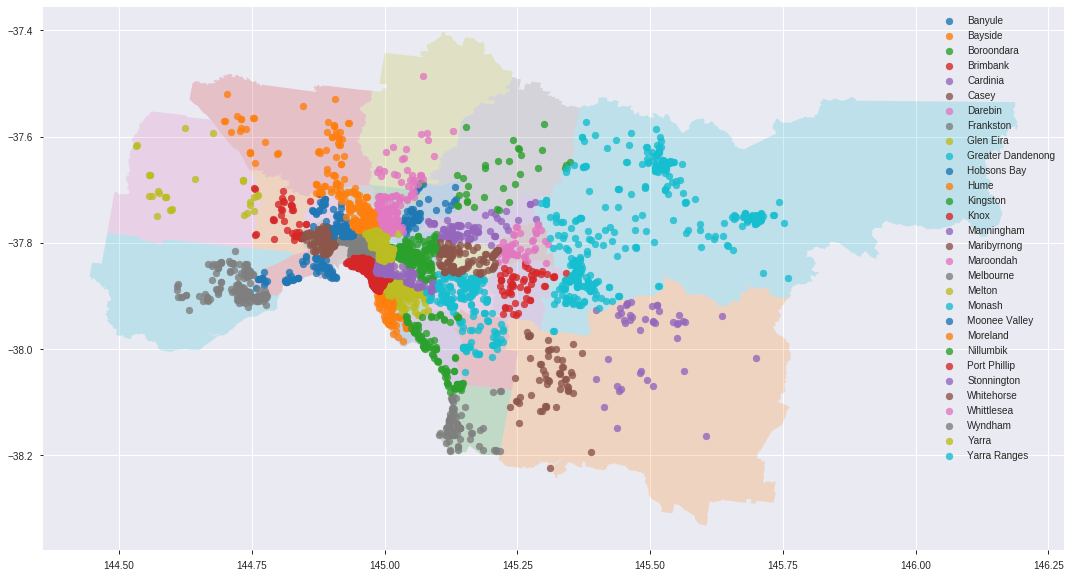

In [0]:
Data= Listings
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
df_places = gpd.read_file('/content/neighbourhoods.geojson')
ax = df_places.plot(column='neighbourhood',alpha=0.21)
scatter_x = Data['longitude'].values
scatter_y = Data['latitude'].values
scatter_s = Data['price'].values
group = Data.nbr.values
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g,alpha=0.8,)
ax.legend()
ax.figure.set_size_inches(20, 10)
plt.show()

In [0]:
def hverify(row):
    return len(row)
def hrt(row):
    return hrt.var[row]
def apart(row):
    return apart.var[row]
def parse(row):
    parsed=row.replace('{',' ').replace('}',' ').split(',')
    return len(parsed)
def fixhiv(row):
    if(row=='t'):
       res=1
    else:
       res=0
    return res     
def fixperc(row):
    res=int(row.replace('%',''))
    return res
Dummy=['bed_type','cancellation_policy','host_response_time'
       ,'property_type','room_type','nbr']
hrtvar=['within an hour', 'within a few hours', 'within a day',
       'a few days or more']
hrtnum=[3,2,1,0]
apartvar=['Entire home/apt', 'Private room', 'Shared room']
apartnum=[2,1,0]
apart.var=dict(zip(apartvar,apartnum))
hrt.var=dict(zip(hrtvar,hrtnum))
Listings['hv']=Listings['host_verifications'].apply(hverify)
Listings['hrt']=Listings['host_response_time'].apply(hrt)
Listings['rt']=Listings['room_type'].apply(apart)
Listings['host_response_rate']=Listings['host_response_rate'].apply(fixperc)
Listings['amenities_num']=Listings['amenities'].apply(parse)
Listings['host_identity_verified']=Listings['host_identity_verified'].apply(fixhiv)
Listings['host_is_superhost']=Listings['host_is_superhost'].apply(fixhiv)
#dummies=pd.get_dummies(Listings,columns=Dummy)
#Listings = pd.concat([Listings, dummies], axis=1, join='inner')
#Listings.head()

Listings.room_type.unique()
Listings.head()
Listings.to_csv('/content/drive/My Drive/Clean.csv')

In [0]:
nums=['host_response_rate', 'host_is_superhost', 'host_identity_verified',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'hv', 'hrt', 'rt',
       'amenities_num', 'res']

textft=['id','name','cancellation_policy','nbr','bed_type','amenities','room_type','property_type',
        'host_verifications','host_response_time','latitude','longitude']
ones=[1]*len(nums)
weights=dict(zip(nums,ones))
Listings.head()

id  ...                                               name
0  12936  ...   St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC
1  38271  ...                 Melbourne - Old Trafford Apartment
2  43414  ...                                   Home In The City
3  43429  ...  Tranquil Javanese-Style Apartment in Oakleigh ...
4  44082  ...                      Queen Room in Beautiful House

[5 rows x 38 columns]

In [0]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
Listings=pd.read_csv('/content/drive/My Drive/listings.csv')
filters={'host_response_time':'within an hour'
        #,'host_verifications':'reviews'
         #,'nbr':'Casey'
         }
verification=['reviews']
amen=['wifi','TV']
def filter(filters,amen,verification,ds):
    for filts in filters:
      ds=ds.loc[ds[filts]==filters[filts]]
    #print(ds.shape)
    for elements in amen:
      ds=ds.loc[ds['amenities'].str.contains(elements)]
    
    for elements in verification:
      ds=ds.loc[ds['host_verifications'].str.contains(elements)]
    return ds
def Cluster(weights,ds,textft,nclusters):
    ss= StandardScaler()
    X= ds.copy()
    X.drop(textft,axis=1,inplace=True) 
    X[:]=ss.fit_transform(X)
    # applying weights
    for label in weights:
        X[label]=weights[label]*X[label]
    #------
    kmeans= KMeans(n_jobs=-1,n_clusters=nclusters)
    X['lables']=kmeans.fit_predict(X=X)
    return X

def describe(res):
    X=res.groupby('lables').describe()
    return X
res=filter(filters,amen,verification,Listings)
des=pd.DataFrame()
if res.shape[0]!=0:
    #print('clustering')
    res=Cluster(weights,res,textft,10)
    #Listings['lables']=res['lables']
    des=describe(res)
print(res.head())
des.head()#des[('host_response_rate', 'count')] this is how elements can be 
# accessed
print(des.head())

     host_response_rate  host_is_superhost  ...       res  lables
34             0.184193           1.368136  ... -0.499449       1
73             0.184193          -0.730922  ... -0.427711       1
99             0.184193          -0.730922  ... -1.664771       1
100            0.184193          -0.730922  ... -0.184741       1
101            0.184193          -0.730922  ... -0.119091       1

[5 rows x 27 columns]
       host_response_rate                          ...       res                    
                    count      mean           std  ...       50%       75%       max
lables                                             ...                              
0                    14.0  0.184193  2.880332e-17  ... -0.086740  0.164036  0.611600
1                     9.0  0.082318  3.056236e-01  ... -0.436712 -0.184741  0.053219
2                    21.0  0.140532  2.000776e-01  ...  0.161784  0.545496  0.944226
3                     1.0 -0.274243           NaN  ... -2.972197 -2.972

In [0]:
Listings.to_csv('id.csv')

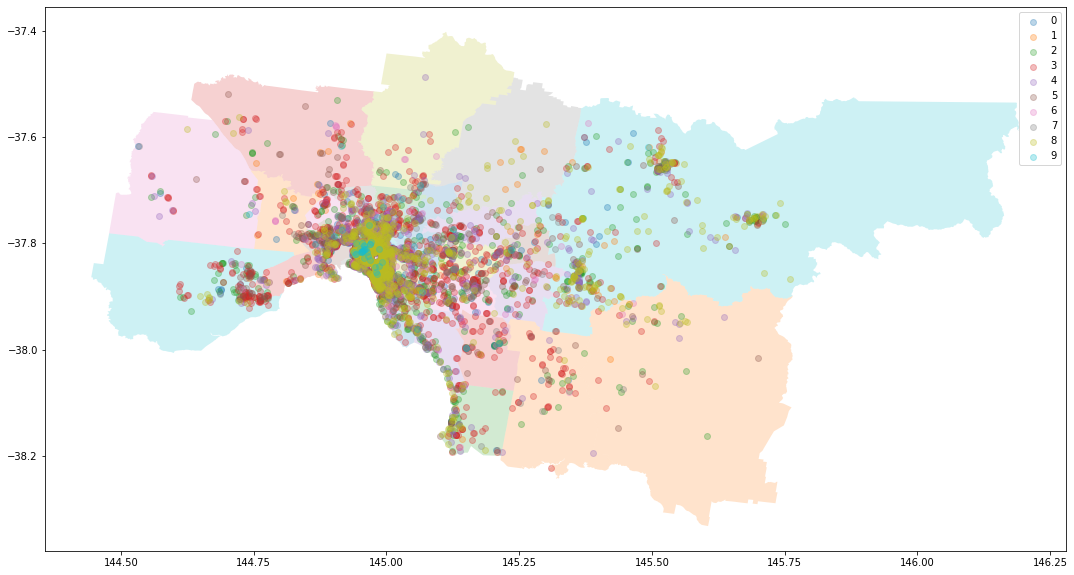

In [0]:
Listings['lables']=res['lables']
Data= Listings
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
df_places = gpd.read_file('/content/neighbourhoods.geojson')
ax = df_places.plot(column='neighbourhood',alpha=0.21)
scatter_x = Data['longitude'].values
scatter_y = Data['latitude'].values
scatter_s = Data['price'].values
group = Data.lables.values
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g,alpha=0.3,)
ax.legend()
ax.figure.set_size_inches(20, 10)
plt.show()

In [0]:
import pandas as pd
import numpy as np

listings = pd.read_csv('listings-v0.1.csv')
listings.loc[listings['price']==0,'price']=np.nan
listings.dropna(inplace=True)
listings.to_csv('listings-v0.2.csv',index=False)
from google.colab import files
files.download('/content/listings-v0.2.csv') 


In [14]:
!git https://git.cs.dal.ca/kma/visualization-proj/tree/PreProcessing
!git --help


git: 'https://git.cs.dal.ca/kma/visualization-proj/tree/PreProcessing' is not a git command. See 'git --help'.
usage: git [--version] [--help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]

These are common Git commands used in various situations:

start a working area (see also: git help tutorial)
   clone      Clone a repository into a new directory
   init       Create an empty Git repository or reinitialize an existing one

work on the current change (see also: git help everyday)
   add        Add file contents to the index
   mv         Move or rename a file, a directory, or a symlink
   reset      Reset current HEAD to the specified state
   rm         Remove files from the working tree and from the index

examine the history and state (see also: 